In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_paths = {'in':'../data/enriched/Ride_to_alum_creek.csv',
              'out':'../data/enriched/Ride_to_alum_creek.csv'
             }

df = pd.read_csv(file_paths['in'])

In [3]:
# convert the time column to a datetime type
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.columns

Index(['track', 'segment', 'time', 'time_utc', 'time_diff', 'elapsed_time',
       'elevation', 'latitude', 'longitude', 'distance', 'elapsed_distance',
       'speed', 'grade'],
      dtype='object')

In [5]:
df.head()

,track,segment,time,time_utc,time_diff,elapsed_time,elevation,latitude,longitude,distance,elapsed_distance,speed,grade
0,0,0,2020-07-12 11:15:01+00:00,1.594553e+09,NaN,NaN,751.0209,40.080766,-83.036139,NaN,NaN,NaN,NaN
1,0,0,2020-07-12 11:15:02+00:00,1.594553e+09,1.0,1.0,751.0209,40.080772,-83.036132,0.000556,0.000556,2.000532,0.000000
2,0,0,2020-07-12 11:15:04+00:00,1.594553e+09,2.0,3.0,750.6928,40.080779,-83.036126,0.000578,0.001134,1.041101,-10.743653
3,0,0,2020-07-12 11:15:05+00:00,1.594553e+09,1.0,4.0,750.6928,40.080786,-83.036120,0.000578,0.001712,2.082202,0.000000
4,0,0,2020-07-12 11:15:07+00:00,1.594553e+09,2.0,6.0,750.6928,40.080792,-83.036115,0.000492,0.002204,0.884990,0.000000


# 1. Segment ID

In [7]:
# find all indices where time gaps are greater than 2 seconds
filt_segment_starts = df.loc[:,'time_diff'] > 2 
segment_starts = df.loc[filt_segment_starts, :]

In [10]:
# we only want the indices of the dataframe where new segments start 
# we must include index=0 as the start of the 0th segment
segment_start_indices = [0] + list(segment_starts.index)
print(len(segment_start_indices))

47


In [12]:
for i in range(0, len(segment_start_indices)):
    # create an index filter starting on the i^th segment's start index
    # end the filter one row before the start of segment i+1
    start_index = segment_start_indices[i]
    if (i == len(segment_start_indices)-1): 
        # if the last segment is being assigned, i+1 will give an index error
        # instead, set the end index to be the last index of the dataframe
        end_index = df.shape[0]-1
    else:
        end_index = segment_start_indices[i+1] - 1
    
    # for all rows between the index endpoints, assign that segment ID = i
    df.loc[start_index:end_index,'segment'] = i    

In [13]:
# because a segment in Strava means a physical stretch of a path, talking about them both is confusing
# we will need to be clearer now to save a headache in the future
# thus, rename the 'segment' column to 'gpx_seg_id'
df = df.rename(columns={'segment':'gpx_seg_id'})

# 2. Plotting Ride Segments

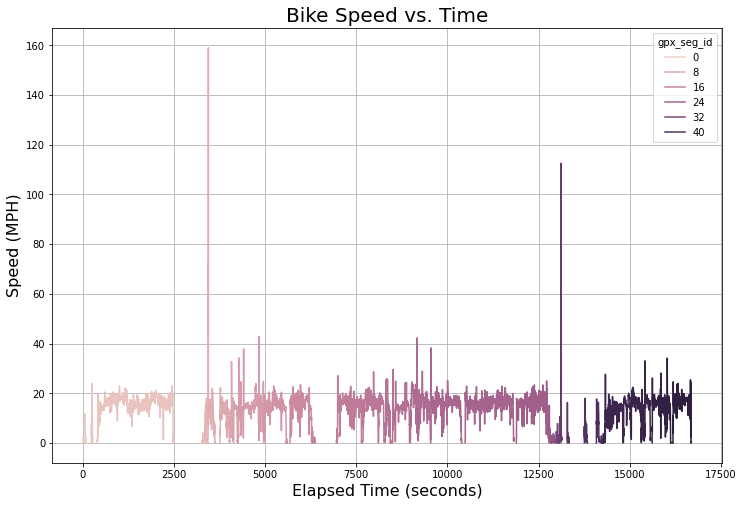

In [16]:
fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='gpx_seg_id')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Speed vs. Time', fontsize=20)
_ = plt.grid()

### Trying a Categorical Palette

In [ ]:
df['gpx_seg_id'] = df['gpx_seg_id'].astype(str)

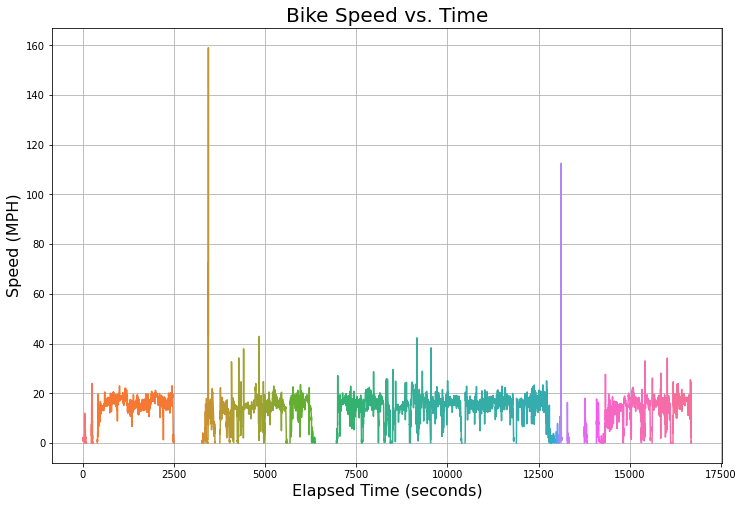

In [27]:
fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='gpx_seg_id', legend=False)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Speed vs. Time', fontsize=20)
_ = plt.grid()

### Building a Limited Categorical Palette

In [25]:
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [34]:
np.array(sns.color_palette("deep"))

array([[0.29803922, 0.44705882, 0.69019608],
       [0.86666667, 0.51764706, 0.32156863],
       [0.33333333, 0.65882353, 0.40784314],
       [0.76862745, 0.30588235, 0.32156863],
       [0.50588235, 0.44705882, 0.70196078],
       [0.57647059, 0.47058824, 0.37647059],
       [0.85490196, 0.54509804, 0.76470588],
       [0.54901961, 0.54901961, 0.54901961],
       [0.8       , 0.7254902 , 0.45490196],
       [0.39215686, 0.70980392, 0.80392157]])

In [49]:
def create_limited_palette(df, category_column, palette_name='deep'):
    # define the total length of the palette object needed to assign colors to @category_column
    num_total_colors = len(df[category_column].unique())
    
    # define the starting palette
    base_palette = np.array(sns.color_palette(palette_name))
    
    # calculate the repetition requirements for full and partial repeats
    num_full_repeats = int(num_total_colors / base_palette.shape[0])
    remainder_repeats = num_total_colors % base_palette.shape[0]
    
    # create the new palette by repeating the base palette
    new_palette = base_palette
    for _ in range(0, num_full_repeats-1): # perform the full repeats
        new_palette = np.vstack((new_palette, base_palette))
    
    # perform the partial repeats for any remainder
    new_palette = np.vstack((new_palette, base_palette[0:remainder_repeats]))
    
    return new_palette


In [51]:
gpx_seg_palette = create_limited_palette(df, 'gpx_seg_id')

C:\Users\Demo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


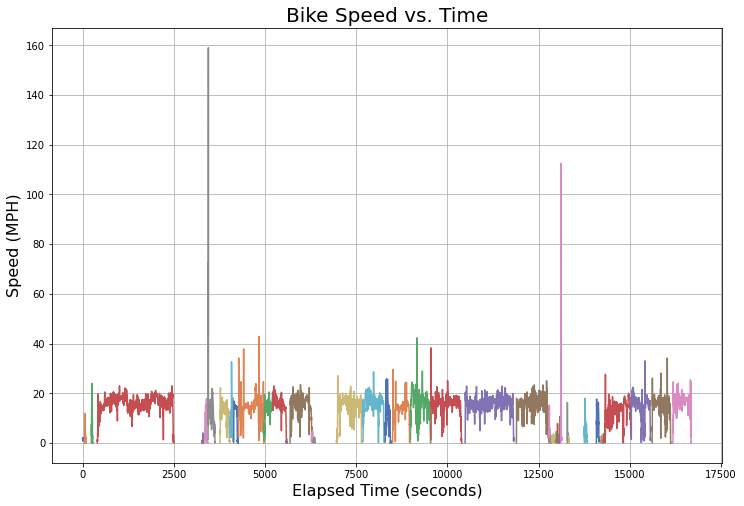

In [52]:
fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='gpx_seg_id', legend=False, palette=gpx_seg_palette)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Speed vs. Time', fontsize=20)
_ = plt.grid()

C:\Users\Demo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


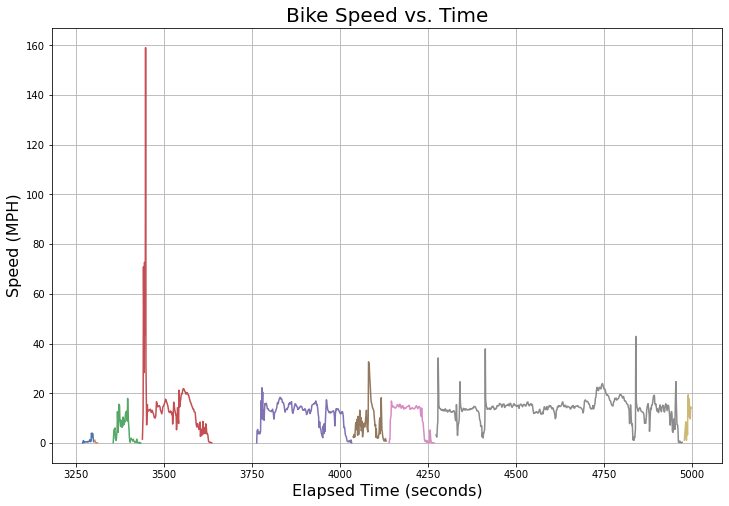

In [53]:
filt_elapsed_time = (df.loc[:,'elapsed_time'] >= 3000) & (df.loc[:,'elapsed_time'] < 5000)

fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='speed', data=df.loc[filt_elapsed_time,:], 
                 hue='gpx_seg_id', legend=False, palette=gpx_seg_palette)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Speed vs. Time', fontsize=20)
_ = plt.grid()

### Checking the Grade Column

C:\Users\Demo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


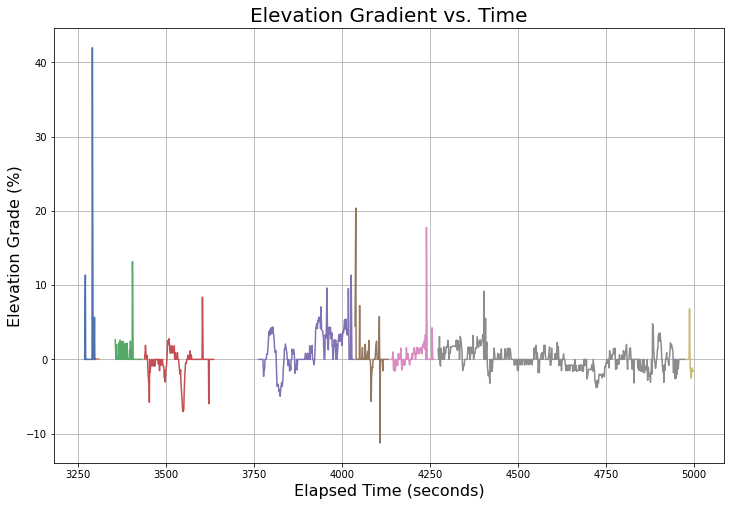

In [54]:
filt_elapsed_time = (df.loc[:,'elapsed_time'] >= 3000) & (df.loc[:,'elapsed_time'] < 5000)

fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='grade', data=df.loc[filt_elapsed_time,:], 
                 hue='gpx_seg_id', legend=False, palette=gpx_seg_palette)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elevation Grade (%)', fontsize=16)
_ = plt.title('Elevation Gradient vs. Time', fontsize=20)
_ = plt.grid()

C:\Users\Demo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


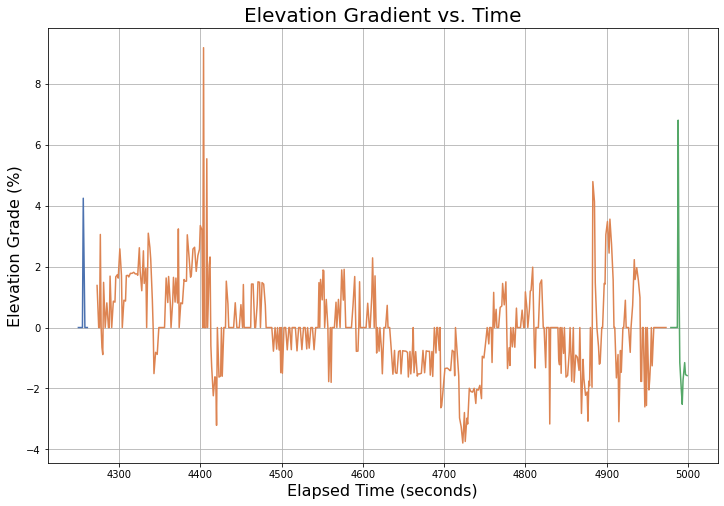

In [55]:
filt_elapsed_time = (df.loc[:,'elapsed_time'] >= 4250) & (df.loc[:,'elapsed_time'] < 5000)

fig = plt.figure(figsize=(12,8))
_ = sns.lineplot(x='elapsed_time', y='grade', data=df.loc[filt_elapsed_time,:], 
                 hue='gpx_seg_id', legend=False, palette=gpx_seg_palette)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elevation Grade (%)', fontsize=16)
_ = plt.title('Elevation Gradient vs. Time', fontsize=20)
_ = plt.grid()